**Table of contents**<a id='toc0_'></a>    
- 1. [Perface](#toc1_)    
- 2. [手写数字为例](#toc2_)    
- 3. [图像生成](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Perface](#toc0_)

What is GAN?

# 2. <a id='toc2_'></a>[手写数字为例](#toc0_)

在 PyTorch 中你可以通过指定损失函数的形式（而不是优化器本身）来控制是“最大化”还是“最小化”。优化器本身（如 torch.optim.Adam）只能做最小化，所以想最大化某个目标，怎么办？
- 你需要将目标函数 f(x) 的负号传进去，使优化器最小化 −f(x)

🔍 实战：GAN 中就这样做了

以生成器为例，GAN 的原始目标是： $\min_G\max_DV(D,G)$

判别器要最大化以下目标：$\mathbb{E}_{x\sim p_\mathrm{data}}[\log D(x)]+\mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))]$

但因为优化器只会 最小化，所以我们写成：
```python
d_loss = - (torch.log(D_real) + torch.log(1 - D_fake)).mean()
d_loss.backward()
optimizer_D.step()
```

>这里我们手动加了负号，把最大化目标变成最小化。

🧠 总结：控制优化方向的方式
| 目的      | 如何实现                                     |
| ------- | ---------------------------------------- |
| 最小化目标函数 | 直接用原始 loss，例如 `loss = criterion(...)`    |
| 最大化目标函数 | 加负号：`loss = -f`，然后仍用优化器 `minimize(loss)` |

>🔧 优化器永远是 “minimize”，所以最大化操作需要你手动加负号。

In [16]:
%load_ext scalene

The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [17]:
%%scalene
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(
    datasets.MNIST(root='./datas', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)


class Generator(nn.Module):
    '''生成器的输入是一个随机噪声向量z，目标是把它“变成”一张图像。'''

    def __init__(self, noise_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()  # 输出范围[-1, 1]
        )
    
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28) # (batch_size, 1, 28, 28)


class Discriminator(nn.Module):
    '''判别器接受图像，输出一个 0~1 的概率，表示“这张图是真实的”。'''

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # 输出范围[0, 1]概率
        )

    def forward(self, x):
        return self.net(x)


Scalene: An exception of type ImportError occurred. Arguments:
("cannot import name 'display' from 'IPython.core.display' (/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/IPython/core/display.py)",)
Traceback (most recent call last):
  File "/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/scalene/scalene_profiler.py", line 2133, in run_profiler
    exit_status = profiler.profile_code(
        code, the_locals, the_globals, left
    )
  File "/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/scalene/scalene_profiler.py", line 1868, in profile_code
    ScaleneJupyter.display_profile(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        port, Scalene.__profiler_html
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/scalene/scalene_jupyter.py", line 35, in display_profile
    from IPython.core.display import display
ImportError: ca

In [5]:
import matplotlib.pyplot as plt 
from deepspore.matplotlib_config import refresh_plot, set_plt_rcParams
set_plt_rcParams()

Epoch 600, D_loss: 0.9001, G_loss: 1.6879


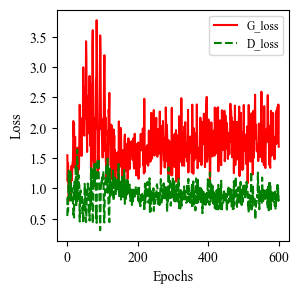

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

fixed_noise = torch.randn(64, 100, device=device)

G_loss_list, D_loss_list = [], [] 

for epoch in range(600):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ========== 训练判别器 ==========
        noise = torch.randn(batch_size, 100, device=device)
        fake_imgs = G(noise)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_loss_real = criterion(D(real_imgs), real_labels)          # 判别器对真实图像的损失
        D_loss_fake = criterion(D(fake_imgs.detach()), fake_labels) # 判别器对伪造图像的损失
        D_loss = D_loss_real + D_loss_fake                          # 判别器总损失

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ========== 训练生成器 ==========
        fake_imgs = G(noise)
        G_loss = criterion(D(fake_imgs), real_labels)               # 生成器希望 D 认为这些是“真实”的图像

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}, D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")
    G_loss_list.append(G_loss.item())
    D_loss_list.append(D_loss.item())
    
    plt.figure(figsize= (3, 3))
    plt.plot(G_loss_list, label='G_loss', color='red', linestyle='-')
    plt.plot(D_loss_list, label='D_loss', color='green', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize='small')
    refresh_plot(fig=plt.gcf())    


In [7]:
def save_model(model:torch.nn.Module, path:str):
    """保存模型到指定路径"""
    torch.save(model.state_dict(), path)
    print(f"模型已保存到 {path}")


save_model(G, 'datas/params/generator.pth')
save_model(D, 'datas/params/discriminator.pth')

模型已保存到 datas/params/generator.pth
模型已保存到 datas/params/discriminator.pth


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

In [9]:
G.load_state_dict(state_dict=torch.load('datas/params/generator.pth'))
D.load_state_dict(state_dict=torch.load('datas/params/discriminator.pth'))

<All keys matched successfully>

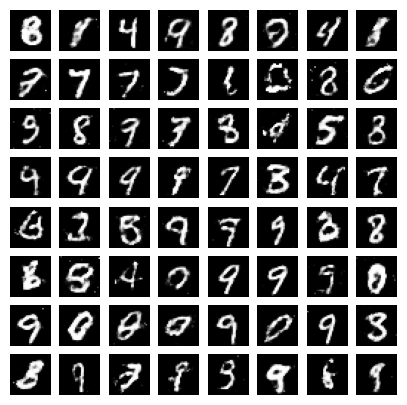

In [13]:
import matplotlib.pyplot as plt

fixed_noise = torch.randn(64, 100, device=device)

G.eval()
with torch.no_grad():
    samples = G(fixed_noise).cpu().view(-1, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(5, 5))
for i in range(64):
    axs[i//8][i%8].imshow((samples[i] + 1)/2, cmap='gray')
    axs[i//8][i%8].axis('off')
# plt.show()


# 3. <a id='toc3_'></a>[图像生成](#toc0_)

In [39]:
from d2l import torch as d2l
import torchvision 


#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip', 'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [41]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(pokemon, batch_size=batch_size, shuffle=True, num_workers=d2l.get_dataloader_workers())

/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/bmp/backup/zhaosy/miniconda3/envs/deeplearning/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


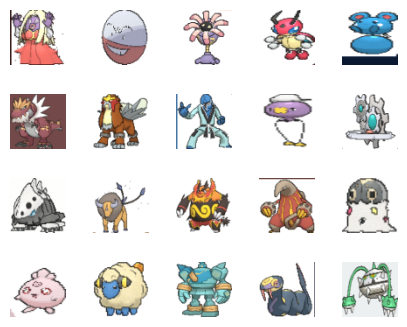

In [81]:
def show_images(imgs:torch.Tensor, num_rows:int, num_cols:int, scale:float = 1.0):
    figsize = (num_cols * scale, num_rows * scale)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    num_img = 0
    for row in range(num_rows):
        for col in range(num_cols):
            axs[row][col].imshow((imgs[num_img]+1)/2)
            axs[row][col].axis('off')  # 去除刻度轴
            axs[row][col].set_frame_on(False)  # ✅ 去除图像边框
            num_img += 1
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    

for X, y in data_iter: 
    imgs = X[:20, :, :, :].permute(0, 2, 3, 1)
    show_images(imgs, num_rows=4, num_cols=5)
    break